# DBLP Dataset Analysis w/ StellarGraph

## Loading data into StellarGraph from Pandas

[The StellarGraph library](https://github.com/stellargraph/stellargraph) supports loading graph information from Pandas. [Pandas](https://pandas.pydata.org) is a library for working with data frames.

The StellarGraph library supports many deep machine learning (ML) algorithms on [graphs](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29). A graph consists of a set of *nodes* connected by *edges*, potentially with information associated with each node and edge. Any task using the StellarGraph library needs data to be loaded into an instance of the `StellarGraph` class. This class stores the graph structure (the nodes and the edges between them), as well as information about them:

- *node types* and *edge types*: a class or category to which the nodes and edges belong, dictating what features are available on a node, and potentially signifying some sort of semantic meaning (this is different to machine learning label for a node)
- *node features* and *edge features*: vectors of numbers associated with each node or edge
- *edge weights*: a number associated with each edge

All of these are optional, because they have sensible defaults if they're not relevant to the task at hand.

> StellarGraph supports loading data from many sources with all sorts of data preprocessing, via [Pandas](https://pandas.pydata.org) DataFrames, [NumPy](https://www.numpy.org) arrays, [Neo4j](https://neo4j.com) and [NetworkX](https://networkx.github.io) graphs. See [all loading demos](README.md) for more details.

The [documentation](https://stellargraph.readthedocs.io/en/stable/api.html#stellargraph.StellarGraph) for the `StellarGraph` class includes a compressed reminder of everything discussed in this file, as well as explanations of all of the parameters.

The `StellarGraph` class is available at the top level of the `stellargraph` library:

In [1]:
from stellargraph import StellarGraph

/Users/kareemrahman/.pyenv/versions/3.6.15/lib/python3.6/site-packages/requests/__init__.py:104: RequestsDependencyWarning: urllib3 (1.26.18) or chardet (5.0.0)/charset_normalizer (2.0.12) doesn't match a supported version!
  RequestsDependencyWarning)


## LastFM Dataset

This dataset contains social networking, tagging, and music artist listening information from a set of 2K users from Last.fm online music system. http://www.last.fm 

The dataset is released in the framework of the 2nd International Workshop on Information Heterogeneity and Fusion in Recommender Systems (HetRec 2011) http://ir.ii.uam.es/hetrec2011 at the 5th ACM Conference on Recommender Systems (RecSys 2011) http://recsys.acm.org/2011 

**artists.dat**
This file contains information about music artists listened and tagged by the users.

**tags.dat**
This file contains the set of tags available in the dataset.

**user_artists.dat**
This file contains the artists listened to by each user. It also provides a listening count for each [user, artist] pair.

**user_taggedartists.dat - user_taggedartists-timestamps.dat**
These files contain the tag assignments of artists provided by each particular user. They also contain the timestamps when the tag assignments were done.

**user_friends.dat**
These files contain the friend relations between users in the database.

### Step 1: Loading from .dat Files in Pandas Dataframes

Pandas DataFrames are tables of data that can be created from [many input sources](https://pandas.pydata.org/pandas-docs/stable/user_guide/io.html), such as [CSV files](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) and [SQL databases](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_sql.html). StellarGraph builds on this power by allowing construction from these DataFrames.

The data is formatted one entry per line as follows (tab separated, "\t")

In [3]:
import pandas as pd

#Set correct directory paths to files
artist_filename = 'lastfm/artists.dat'
tags_filename = 'lastfm/tags.dat'
user_artist_filename = 'lastfm/user_artists.dat'
tag_artist_filename = 'lastfm/user_taggedartists.dat'
user_user_filename = 'lastfm/user_friends.dat'

# Read the file and create Node Dataframes
artists_df = pd.read_csv(artist_filename, delimiter='\t', header=0, encoding = 'ISO-8859-1')
tags_df = pd.read_csv(tags_filename, delimiter='\t', header=0, encoding = 'ISO-8859-1')
users_df = pd.read_csv(user_artist_filename, delimiter='\t', header=0, encoding = 'ISO-8859-1')

# Read the file and create Edge Dataframes
user_artist_df = pd.read_csv(user_artist_filename, delimiter='\t', header=0, encoding = 'ISO-8859-1')
tag_artist_df = pd.read_csv(tag_artist_filename, delimiter='\t', header=0, encoding = 'ISO-8859-1')
user_user_df = pd.read_csv(user_user_filename, delimiter='\t', header=0, encoding = 'ISO-8859-1')

# Remove unnecessary columns in Dataframes as needed
artists_df_keep = ["id", "name"]
users_df_keep = ["userID"]
tag_artist_keep = ["artistID", "tagID"]
user_artist_keep = ["userID", "artistID"]

artists_df = artists_df[artists_df_keep]
users_df = users_df[users_df_keep]
tag_artist_df = tag_artist_df[tag_artist_keep]
user_artist_df = user_artist_df[user_artist_keep]

#Remove duplicates in users_df Node Dataframe to isolate individual unique users
users_df = users_df.drop_duplicates().reset_index(drop=True)

# Display the first few rows
print(artists_df.head())
print("\n")
print(tags_df.head())
print("\n")
print(users_df.head())
print("\n")
print(user_artist_df.head())
print("\n")
print(tag_artist_df.head())
print("\n")
print(user_user_df.head())

   id               name
0   1       MALICE MIZER
1   2    Diary of Dreams
2   3  Carpathian Forest
3   4       Moi dix Mois
4   5        Bella Morte


   tagID           tagValue
0      1              metal
1      2  alternative metal
2      3          goth rock
3      4        black metal
4      5        death metal


   userID
0       2
1       3
2       4
3       5
4       6


   userID  artistID
0       2        51
1       2        52
2       2        53
3       2        54
4       2        55


   artistID  tagID
0        52     13
1        52     15
2        52     18
3        52     21
4        52     41


   userID  friendID
0       2       275
1       2       428
2       2       515
3       2       761
4       2       831


## Loading Pandas DFs into StellarGraph

### Defining Node Data

Assuming IDs for each node type are unique, then we can use these to index the dataframe for each node-type. We also need to remove the names from each data frame, as StellarGraph only passes numeric data.

In [4]:
# Copy original DataFrames
processed_artists_df = artists_df.copy()
processed_tags_df = tags_df.copy()
processed_users_df = users_df.copy()
processed_user_artist_df = user_artist_df.copy()
processed_tag_artist_df = tag_artist_df.copy()
processed_user_user_df = user_user_df.copy()


# Apply processing steps

# Set ID columns as index and add prefix in Node Dataframes
processed_artists_df.set_index('id', inplace=True)
processed_artists_df.index = processed_artists_df.index.map(lambda x: f'a_{x}')

processed_tags_df.set_index('tagID', inplace=True)
processed_tags_df.index = processed_tags_df.index.map(lambda x: f't_{x}')

processed_users_df.set_index('userID', inplace=True)
processed_users_df.index = processed_users_df.index.map(lambda x: f'u_{x}')

# Update Edge DataFrames
processed_user_artist_df['userID'] = processed_user_artist_df['userID'].map(lambda x: f'u_{x}')
processed_user_artist_df['artistID'] = processed_user_artist_df['artistID'].map(lambda x: f'a_{x}')

processed_tag_artist_df['artistID'] = processed_tag_artist_df['artistID'].map(lambda x: f'a_{x}')
processed_tag_artist_df['tagID'] = processed_tag_artist_df['tagID'].map(lambda x: f't_{x}')

processed_user_user_df['userID'] = processed_user_user_df['userID'].map(lambda x: f'u_{x}')
processed_user_user_df['friendID'] = processed_user_user_df['friendID'].map(lambda x: f'u_{x}')

#Remove columns with String values, as StellarGraph only passes numeric formats
processed_artists_df.drop(columns=['name'], inplace=True, errors='ignore')
processed_tags_df.drop(columns=['tagValue'], inplace=True, errors='ignore')

#Rename Edge DataFrames columns as source and target respectively
processed_user_artist_df.rename(columns={'userID': 'source', 'artistID': 'target'}, inplace=True)
processed_tag_artist_df.rename(columns={'artistID': 'source', 'tagID': 'target'}, inplace=True)
processed_user_user_df.rename(columns={'userID': 'source', 'friendID': 'target'}, inplace=True)


print(processed_artists_df)
print("\n")
print(processed_tags_df)
print("\n")
print(processed_users_df)
print("\n")
print(processed_user_artist_df)
print("\n")
print(processed_tag_artist_df)
print("\n")
print(processed_user_user_df)
print("\n")

# Check for unique indices in node DataFrames
print("Duplicate indices in artists:", processed_artists_df.index.duplicated().any())
print("Duplicate indices in tags:", processed_tags_df.index.duplicated().any())
print("Duplicate indices in users:", processed_users_df.index.duplicated().any())


Empty DataFrame
Columns: []
Index: [a_1, a_2, a_3, a_4, a_5, a_6, a_7, a_8, a_9, a_10, a_11, a_12, a_13, a_15, a_16, a_17, a_18, a_19, a_20, a_21, a_22, a_23, a_24, a_25, a_26, a_27, a_28, a_30, a_31, a_32, a_34, a_36, a_37, a_38, a_39, a_40, a_41, a_43, a_44, a_45, a_46, a_47, a_48, a_49, a_50, a_51, a_52, a_53, a_54, a_55, a_56, a_57, a_58, a_59, a_60, a_61, a_62, a_63, a_64, a_65, a_66, a_67, a_68, a_69, a_70, a_71, a_72, a_73, a_74, a_75, a_76, a_77, a_78, a_79, a_80, a_81, a_82, a_83, a_84, a_85, a_86, a_87, a_88, a_89, a_90, a_91, a_92, a_93, a_94, a_95, a_96, a_97, a_98, a_99, a_100, a_101, a_102, a_103, a_104, a_105, ...]

[17632 rows x 0 columns]


Empty DataFrame
Columns: []
Index: [t_1, t_2, t_3, t_4, t_5, t_6, t_7, t_8, t_9, t_10, t_11, t_12, t_13, t_14, t_15, t_16, t_17, t_18, t_19, t_20, t_21, t_22, t_23, t_24, t_25, t_26, t_27, t_28, t_29, t_30, t_31, t_32, t_33, t_34, t_35, t_36, t_37, t_38, t_39, t_40, t_41, t_42, t_43, t_44, t_45, t_46, t_47, t_48, t_49, t_50, t_51, t

### Removing Duplicates in Node DFs + Check for Uniqueness

Any duplications in node indexes within the node DFs is problematic and must be resolved.

In [5]:
#Convert indices to Series and then concatenate
all_ids = pd.concat([processed_artists_df.index.to_series(), 
                     processed_tags_df.index.to_series(), 
                     processed_users_df.index.to_series()])

#Check for duplicate IDs across all node types
duplicated_ids = all_ids[all_ids.duplicated()]
if not duplicated_ids.empty:
    print("There are duplicate IDs across node types.")
    print("Duplicate IDs:", duplicated_ids.unique())
else:
    print("No duplicate IDs across node types.")

#Check if IDs contain unique values after string concatenation 
print("All concatenated IDs are unique:", all_ids.is_unique)

No duplicate IDs across node types.
All concatenated IDs are unique: True


### Removing Duplicates in Edge DFs

Any two edges that are identical in the edge DFs must be resolved. We drop the duplicates after this step.

In [6]:

#Check for and drop duplicates in 'listens to' relationship
if processed_user_artist_df.duplicated().any():
    print("There are duplicate edges in 'listens to' relationship.")
    duplicate_edges_listens = processed_user_artist_df[processed_user_artist_df.duplicated(keep=False)]
    print("Duplicate edges in 'listens to' relationship:")
    print(duplicate_edges_listens)
    processed_user_artist_df = processed_user_artist_df.drop_duplicates()
else:
    print("No duplicate edges in 'listens to' relationship.")

#Check for and drop duplicates in 'tagged on' relationship
if processed_tag_artist_df.duplicated().any():
    print("There are duplicate edges in 'tagged on' relationship.")
    duplicate_edges_tagged = processed_tag_artist_df[processed_tag_artist_df.duplicated(keep=False)]
    print("Duplicate edges in 'tagged on' relationship:")
    print(duplicate_edges_tagged)
    processed_tag_artist_df = processed_tag_artist_df.drop_duplicates()
else:
    print("No duplicate edges in 'tagged on' relationship.")

#Check for and drop duplicates in 'friends with' relationship
if processed_user_user_df.duplicated().any():
    print("There are duplicate edges in 'friends with' relationship.")
    duplicate_edges_friends = processed_user_user_df[processed_user_user_df.duplicated(keep=False)]
    print("Duplicate edges in 'friends with' relationship:")
    print(duplicate_edges_friends)
    processed_user_user_df = processed_user_user_df.drop_duplicates()
else:
    print("No duplicate edges in 'friends with' relationship.")


No duplicate edges in 'listens to' relationship.
There are duplicate edges in 'tagged on' relationship.
Duplicate edges in 'tagged on' relationship:
        source  target
0         a_52    t_13
1         a_52    t_15
2         a_52    t_18
3         a_52    t_21
5         a_63    t_13
...        ...     ...
186467  a_6658  t_2087
186469  a_8322     t_4
186470  a_8322  t_3510
186471  a_8322  t_4364
186472  a_8322  t_4365

[100151 rows x 2 columns]
No duplicate edges in 'friends with' relationship.


### Checking for Unconnected Nodes

In order for the random walks to cover ALL nodes and generate embeddings for each one, only nodes that are connected to others as part of the graph can be considered. We check for unconnected nodes by inspecting the edge dataframes and cross-checking with the node dataframes. 

If any index is in the node DF BUT NOT in ANY edge DF, THEN we drop it. 

In [7]:
# Users not connected to artists or other users
isolated_users = processed_users_df.index[
    ~processed_users_df.index.isin(processed_user_artist_df['source']) &
    ~processed_users_df.index.isin(processed_user_user_df['source']) &
    ~processed_users_df.index.isin(processed_user_user_df['target'])
]
if not isolated_users.empty:
    print("Isolated user nodes:")
    print(isolated_users)
else:
    print("No isolated user nodes.")

# Artists not connected to users or tags
isolated_artists = processed_artists_df.index[
    ~processed_artists_df.index.isin(processed_user_artist_df['target']) &
    ~processed_artists_df.index.isin(processed_tag_artist_df['source'])
]
if not isolated_artists.empty:
    print("Isolated artist nodes:")
    print(isolated_artists)
else:
    print("No isolated artist nodes.")


# Tags not connected to artists
isolated_tags = processed_tags_df.index[
    ~processed_tags_df.index.isin(processed_tag_artist_df['target'])
]
if not isolated_tags.empty:
    print("Isolated tag nodes:")
    print(isolated_tags)
else:
    print("No isolated tag nodes.")

No isolated user nodes.
No isolated artist nodes.
Isolated tag nodes:
Index(['t_60', 't_106', 't_107', 't_110', 't_111', 't_125', 't_126', 't_133',
       't_150', 't_151',
       ...
       't_12621', 't_12623', 't_12624', 't_12625', 't_12628', 't_12629',
       't_12634', 't_12636', 't_12637', 't_12648'],
      dtype='object', name='tagID', length=2197)


### Deleting Unconnected Nodes from Node DFs

If a node isn't connected to any other node through edges, it doesn't contribute to the relational information captured by your graph. Removing such nodes can streamline your data and potentially speed up computations, especially for graph algorithms that rely on edge connections. Moreover, since these nodes do not participate in any walks, they wouldn't be included in your Word2Vec training corpus anyway, making their removal from the node lists reasonable.

If any index is in the node DF BUT NOT in ANY edge DF, THEN we drop it. 

In [8]:
# Assuming `isolated_users` contains the indexes of isolated user nodes
processed_users_df = processed_users_df.drop(isolated_users, errors='ignore')

# Assuming `isolated_artists` contains the indexes of isolated artist nodes
processed_artists_df = processed_artists_df.drop(isolated_artists, errors='ignore')

# Assuming `isolated_tags` contains the indexes of isolated tag nodes
processed_tags_df = processed_tags_df.drop(isolated_tags, errors='ignore')

### Analyzing Tag Occurence + Denoising Data

We realized that there was an overwhelmingly large number of tags in the LastFM dataset. Since users are the ones assigning tags to artists, it came to our attention that there were a lot of ambiguous tags like "awesome" or "top 10", which don't add much meaning to our analysis, and could instead cause a lot of noise, as well as unnecessary additional computational overhead. We've already identified in the previous steps that there were already around 2200 isolated tag nodes to be removed.

We first look at the fequency distribution of tags used in the dataset, in order to point out the most popular ones. We will also investigate which artists have only one tag assigned to them. as those tags will be kept, in order to maintain as much meaning during the removal of noise.

After deciding which tags can be removed, we will update the tags node dataframe and the artist_tag edge dataframe.

First, we calculate a frequency table based on occurence of each tag in the tag_artist edge dataframe.

In [9]:

tagswnames_df = tags_df.copy()
tagswnames_df.set_index('tagID', inplace=True)
tagswnames_df.index = tagswnames_df.index.map(lambda x: f't_{x}')


# Calculate tag frequency distribution
tag_frequency = processed_tag_artist_df['target'].value_counts().reset_index()
tag_frequency.columns = ['tagID', 'frequency']

# Merge tag names into the tag_frequency DataFrame
tag_frequency_with_names = pd.merge(tag_frequency, tagswnames_df, left_on='tagID', right_on='tagID', how='left')

display(tag_frequency_with_names)


,tagID,frequency,tagValue
0,t_73,2283,rock
1,t_18,1749,electronic
2,t_79,1743,alternative
3,t_24,1739,pop
4,t_81,1537,indie
...,...,...,...
9744,t_8824,1,accordian
9745,t_4561,1,legend of music
9746,t_1852,1,groove armada
9747,t_2428,1,whitechapel


Then, we create a list of keywords by detailing genres and moods, allowing us to filter only words that have these keywords in them. Please note that this is NOT an exhaustive list, neither is it ideal. There could be tags filtered out, which ultimately may have been meaningful to keep, but iterating through thousands of tags and manually removing each is impractical/computationally inefficient.

In [10]:
# Combining the expanded list of music genres and moods for filtering
expanded_retention_keywords = [
    'Rock', 'Pop', 'Jazz', 'Blues', 'Classical', 'Hip Hop', 'Rap', 'EDM', 'House', 'Techno', 'Trance', 'Dubstep',
    'Drum and Bass', 'Ambient', 'Chillout', 'Reggae', 'Dancehall', 'Ska', 'Punk', 'Metal', 'Heavy Metal', 'Black Metal',
    'Death Metal', 'Thrash Metal', 'Doom Metal', 'Folk Metal', 'Power Metal', 'Country', 'Folk', 'Soul', 'R&B', 'Gospel',
    'Funk', 'Disco', 'Grunge', 'Indie', 'Indie Rock', 'Indie Pop', 'Alternative', 'Alternative Rock', 'Alternative Pop',
    'World Music', 'Latin', 'Drill', 'Jungle' , 'Trance', 'Salsa', 'Reggaeton', 'Bachata', 'Merengue', 'Afrobeat', 'K-Pop', 'J-Pop', 'C-Pop', 'Samba',
    'Bossa Nova', 'New Age', 'Opera', 'Electronic', 'Ambient Electronic', 'Synthwave', 'Vaporwave', 'Experimental',
    'Energetic', 'Relaxing', 'Happy', 'Sad', 'Romantic', 'Melancholic', 'Angry', 'Chill', 'Uplifting', 'Mysterious',
    'Dreamy', 'Nostalgic', 'Aggressive', 'Calm', 'Soothing', 'Dark', 'Light', 'Groovy', 'Moody', 'Reflective',
    'Inspirational', 'Tranquil', 'Intense', 'Lively', '80', '90', '70', '60'
]

# Lowercasing all keywords for case-insensitive matching
expanded_retention_keywords = [keyword.lower() for keyword in expanded_retention_keywords]

# Creating a pattern to match any of the expanded retention keywords
expanded_retention_pattern = '|'.join(expanded_retention_keywords)

# Filtering the tags DataFrame to only include rows where the 'tagValue' contains any of the expanded keywords
expanded_filtered_tags_df = tag_frequency_with_names[tag_frequency_with_names['tagValue'].str.contains(expanded_retention_pattern, case=False, na=False)]

display(expanded_filtered_tags_df)

,tagID,frequency,tagValue
0,t_73,2283,rock
1,t_18,1749,electronic
2,t_79,1743,alternative
3,t_24,1739,pop
4,t_81,1537,indie
...,...,...,...
9725,t_883,1,philly soul
9731,t_7085,1,indie rock e alternative
9732,t_7214,1,intelligent techno
9735,t_9701,1,indiepop


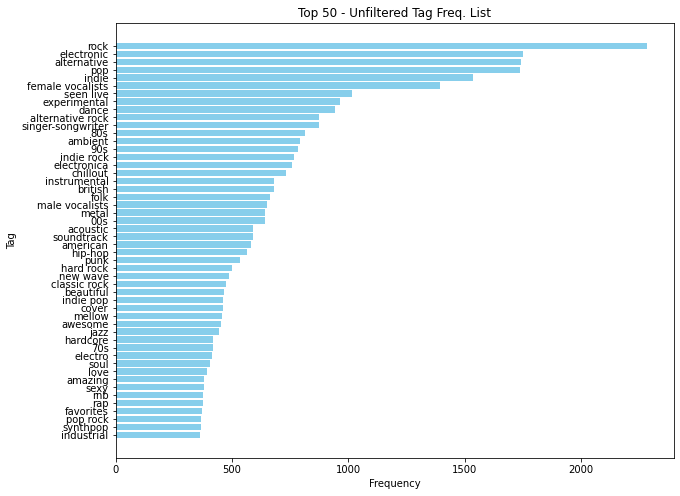

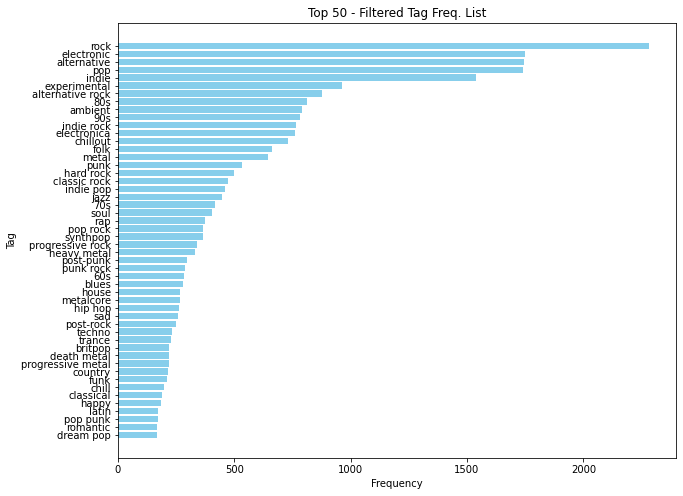

In [11]:
import matplotlib.pyplot as plt

# Assuming you want to plot the top N most frequent tags
N = 50
top_tags1 = tag_frequency_with_names.sort_values(by='frequency', ascending=False).head(N)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(top_tags1['tagValue'], top_tags1['frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Tag')
plt.title('Top 50 - Unfiltered Tag Freq. List')
plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent tag at the top
plt.show()


top_tags2 = expanded_filtered_tags_df.sort_values(by='frequency', ascending=False).head(N)

# Plotting
plt.figure(figsize=(10, 8))
plt.barh(top_tags2['tagValue'], top_tags2['frequency'], color='skyblue')
plt.xlabel('Frequency')
plt.ylabel('Tag')
plt.title('Top 50 - Filtered Tag Freq. List')
plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent tag at the top
plt.show()

Additional Information: We were also interested to know how many tags were exlcusively connected to an artist, i.e., if we were to remove it, the artist would have no other tags connected to it. Would that mean that meaning is lost? Or do we hope that our meta-path guided random walks can connected to other tags by seeing similar artists?

In [12]:
# Count how many tags each artist has
artist_tag_count = processed_tag_artist_df.groupby('source')['target'].nunique().reset_index()
artist_tag_count.columns = ['artist_id', 'tag_count']

# Filter artists with only one tag
sole_tag_artists = artist_tag_count[artist_tag_count['tag_count'] == 1]

# Find the tags that are the sole tag for any artist
sole_tags = pd.merge(sole_tag_artists, processed_tag_artist_df, left_on='artist_id', right_on='source', how='left')['target'].unique()

display(len(sole_tags))

719

### Updating Tags Node DF

After filtering out tags, we need to update the **processed_tags_df**. 

IMPORTANT: **processed_tag_artist_df** dataframe will be updated automatically in the next step when invalid edges are checked and removed.

In [13]:
display(processed_tags_df)

""
tagID
t_1
t_2
t_3
t_4
t_5
...
t_12643
t_12644
t_12645


In [14]:
# Filter processed_tags_df to keep only tagIDs that are present in expanded_filtered_tags_df
# Assuming tagID is the index in processed_tags_df
filtered_processed_tags_df = processed_tags_df[processed_tags_df.index.isin(expanded_filtered_tags_df['tagID'])]

display(filtered_processed_tags_df)

""
tagID
t_1
t_2
t_3
t_4
t_5
...
t_12631
t_12633
t_12635


### Checking for Invalid Edges

Also, any edges that refer to nodes that are NOT in the node dataframe are considered invalid. These must also be dropped so that we can use StellarGraph.

In [15]:
# Check for invalid edge references in 'listens to' relationship
invalid_edges_listens = processed_user_artist_df[
    ~processed_user_artist_df['source'].isin(processed_users_df.index) |
    ~processed_user_artist_df['target'].isin(processed_artists_df.index)
]
if not invalid_edges_listens.empty:
    print("Invalid edges in 'listens to' relationship:")
    print(invalid_edges_listens)
else:
    print("No invalid edges in 'listens to' relationship.")

# Check for invalid edge references in 'tagged on' relationship
invalid_edges_tagged = processed_tag_artist_df[
    ~processed_tag_artist_df['source'].isin(processed_artists_df.index) |
    ~processed_tag_artist_df['target'].isin(filtered_processed_tags_df.index)
]
if not invalid_edges_tagged.empty:
    print("Invalid edges in 'tagged on' relationship:")
    print(invalid_edges_tagged)
else:
    print("No invalid edges in 'tagged on' relationship.")

# Check for invalid edge references in 'friends with' relationship
invalid_edges_friends = processed_user_user_df[
    ~processed_user_user_df['source'].isin(processed_users_df.index) |
    ~processed_user_user_df['target'].isin(processed_users_df.index)
]
if not invalid_edges_friends.empty:
    print("Invalid edges in 'friends with' relationship:")
    print(invalid_edges_friends)
else:
    print("No invalid edges in 'friends with' relationship.")


testid = 'a_14103'

if testid in processed_artists_df.index:
    print(f"The ID {testid} is in the DataFrame index.")
else:
    print(f"The ID {testid} is not in the DataFrame index.")

No invalid edges in 'listens to' relationship.
Invalid edges in 'tagged on' relationship:
         source target
1          a_52   t_15
3          a_52   t_21
4          a_52   t_41
8          a_63   t_40
11         a_73   t_15
...         ...    ...
186455  a_18717  t_758
186456  a_18719  t_758
186457  a_18721   t_15
186458  a_18721  t_758
186462  a_18724   t_15

[67136 rows x 2 columns]
No invalid edges in 'friends with' relationship.
The ID a_14103 is not in the DataFrame index.


It seems that there are invalid edges in the 'tagged on' Edge Dataframe between Artists and Tags (i.e., a_14103 is not found in the Artist node Dataframe). For this reason, we will drop these edges from the dataframe.

In [16]:
# invalid_edges_tagged is the DataFrame containing the invalid rows
# Drop these rows from processed_tag_artist_df
processed_tag_artist_df = processed_tag_artist_df.drop(invalid_edges_tagged.index)

# Reset the index for a continuous index after the drop
processed_tag_artist_df.reset_index(drop=True, inplace=True)

### Final Check for StellarGraph Input

In [17]:
#Check if data types are all matching for suitable StellarGraph input

# Print data types of indices of node DataFrames
print("Data type of artists_df index:", processed_artists_df.index.dtype)
print("Data type of tags_df index:", filtered_processed_tags_df.index.dtype)
print("Data type of users_df index:", processed_users_df.index.dtype)

# Check if node numbers are consistent
print(processed_artists_df)
print("\n")
print(filtered_processed_tags_df)
print("\n")
print(processed_users_df)
print("\n")


# Print data types of 'source' and 'target' in edge DataFrames
print("Data type of source in user_artist_df:", processed_user_artist_df['source'].dtype)
print("Data type of target in user_artist_df:", processed_user_artist_df['target'].dtype)
print("Data type of source in tag_artist_df:", processed_tag_artist_df['source'].dtype)
print("Data type of target in tag_artist_df:", processed_tag_artist_df['target'].dtype)
print("Data type of source in user_user_df:", processed_user_user_df['source'].dtype)
print("Data type of target in user_user_df:", processed_user_user_df['target'].dtype)

# Check if edge numbers are consistent
print(processed_user_artist_df)
print("\n")
print(processed_tag_artist_df)
print("\n")
print(processed_user_user_df)
print("\n")

Data type of artists_df index: object
Data type of tags_df index: object
Data type of users_df index: object
Empty DataFrame
Columns: []
Index: [a_1, a_2, a_3, a_4, a_5, a_6, a_7, a_8, a_9, a_10, a_11, a_12, a_13, a_15, a_16, a_17, a_18, a_19, a_20, a_21, a_22, a_23, a_24, a_25, a_26, a_27, a_28, a_30, a_31, a_32, a_34, a_36, a_37, a_38, a_39, a_40, a_41, a_43, a_44, a_45, a_46, a_47, a_48, a_49, a_50, a_51, a_52, a_53, a_54, a_55, a_56, a_57, a_58, a_59, a_60, a_61, a_62, a_63, a_64, a_65, a_66, a_67, a_68, a_69, a_70, a_71, a_72, a_73, a_74, a_75, a_76, a_77, a_78, a_79, a_80, a_81, a_82, a_83, a_84, a_85, a_86, a_87, a_88, a_89, a_90, a_91, a_92, a_93, a_94, a_95, a_96, a_97, a_98, a_99, a_100, a_101, a_102, a_103, a_104, a_105, ...]

[17632 rows x 0 columns]


Empty DataFrame
Columns: []
Index: [t_1, t_2, t_3, t_4, t_5, t_6, t_7, t_11, t_13, t_14, t_17, t_18, t_19, t_22, t_23, t_24, t_25, t_33, t_35, t_36, t_42, t_43, t_50, t_56, t_65, t_70, t_72, t_73, t_74, t_75, t_76, t_77, t_78

We can modify the approach to create unique numerical IDs across all edge DataFrames. To do this, you can concatenate all edge DataFrames, create a unique numerical ID, and then split them back. This way, each edge in the entire dataset will have a unique ID.

This approach ensures that each edge across all your relationships ('listens to', 'tagged on', 'friends with') has a unique, numerical identifier.

In [18]:
# 1. Concatenate all edge DataFrames with an additional column for edge type
all_edges = pd.concat([
    processed_user_artist_df.assign(edge_type="listens to"),
    processed_tag_artist_df.assign(edge_type="tagged on"),
    processed_user_user_df.assign(edge_type="friends with")
]).reset_index(drop=True)

# 2. Add unique numerical edge IDs
all_edges['edge_id'] = range(all_edges.shape[0])

# 3. Split the DataFrames back
processed_user_artist_df = all_edges[all_edges['edge_type'] == "listens to"].drop('edge_type', axis=1)
processed_tag_artist_df = all_edges[all_edges['edge_type'] == "tagged on"].drop('edge_type', axis=1)
processed_user_user_df = all_edges[all_edges['edge_type'] == "friends with"].drop('edge_type', axis=1)

### Passing DFs into StellarGraph Function

In [19]:
# Create the StellarGraph object with processed data
g = StellarGraph({
    "artist": processed_artists_df,
    "tag": filtered_processed_tags_df,
    "user": processed_users_df
}, {
    "listens to": processed_user_artist_df,
    "tagged on": processed_tag_artist_df,
    "friends with": processed_user_user_df,
})

print(
    "Number of nodes {} and number of edges {} in graph.".format(
        g.number_of_nodes(), g.number_of_edges()
    )
)

print("\n")

print("Below is an overview of the StellarGraph structure:")
print(g.info())

Number of nodes 21526 and number of edges 160882 in graph.


Below is an overview of the StellarGraph structure:


StellarGraph: Undirected multigraph
 Nodes: 21526, Edges: 160882

 Node types:
  artist: [17632]
    Features: none
    Edge types: artist-listens to->user, artist-tagged on->tag
  tag: [2002]
    Features: none
    Edge types: tag-tagged on->artist
  user: [1892]
    Features: none
    Edge types: user-friends with->user, user-listens to->artist

 Edge types:
    artist-listens to->user: [92834]
        Weights: all 1 (default)
        Features: float32 vector, length 1
    artist-tagged on->tag: [42614]
        Weights: all 1 (default)
        Features: float32 vector, length 1
    user-friends with->user: [25434]
        Weights: all 1 (default)
        Features: float32 vector, length 1


## Graph Analysis

After creating a StellarGraph object, we convert it to NetworkX, since it has a larger library of functions related to graph analysis and statistics.

In [20]:
import matplotlib.pyplot as plt
import networkx as nx

In [21]:
# Convert to NetworkX graph
nx_graph = g.to_networkx()

### Degree Distribution of Multi-type Nodes

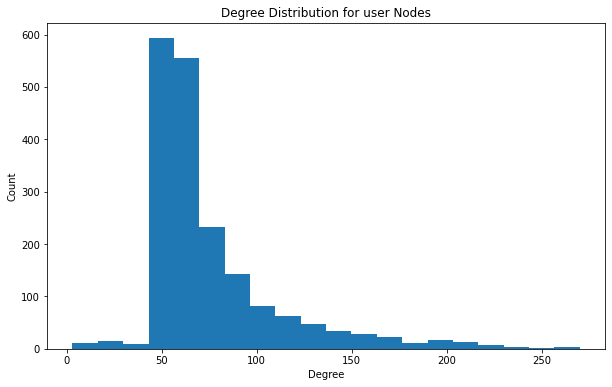

Average Degree for user Nodes: 75.95243128964059


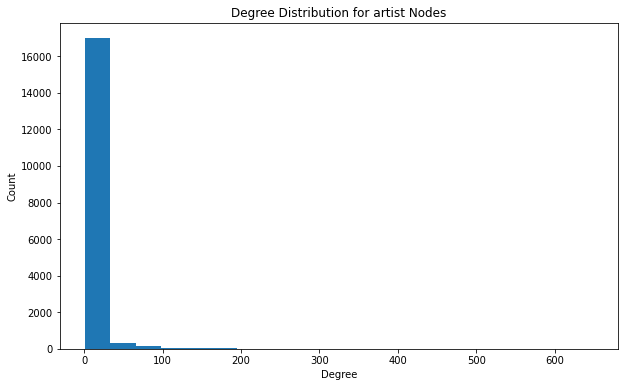

Average Degree for artist Nodes: 7.681941923774954


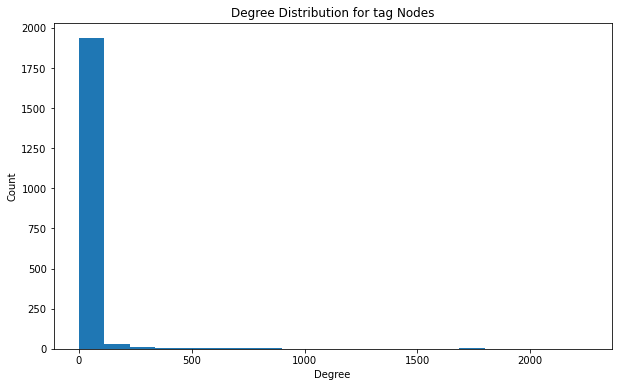

Average Degree for tag Nodes: 21.285714285714285


In [22]:
node_types = g.node_types

# Get node types
node_types = set(nx.get_node_attributes(nx_graph, 'label').values())  # Assuming 'label' is the attribute holding node types

# Calculate and plot degree distribution for each node type
for node_type in node_types:
    # Filter nodes by type
    nodes_of_type = [n for n, d in nx_graph.nodes(data=True) if d.get('label') == node_type]
    # Calculate degrees
    degrees = [nx_graph.degree(n) for n in nodes_of_type]
    # Plotting
    plt.figure(figsize=(10, 6))
    plt.hist(degrees, bins=20)
    plt.title(f"Degree Distribution for {node_type} Nodes")
    plt.xlabel('Degree')
    plt.ylabel('Count')
    plt.show()

    # Average degree calculation
    avg_degree = sum(degrees) / len(degrees)
    print(f"Average Degree for {node_type} Nodes: {avg_degree}")

In [23]:
# Calculate the sum of the degrees of all nodes
total_degree = sum(dict(nx_graph.degree()).values())

# Calculate the number of nodes in the graph
num_nodes = nx_graph.number_of_nodes()

# Calculate the average degree
average_degree = total_degree / num_nodes if num_nodes > 0 else 0

print(f"Average Degree of the Graph: {average_degree}")

Average Degree of the Graph: 14.947691164173557


### Portion of Different Node Types

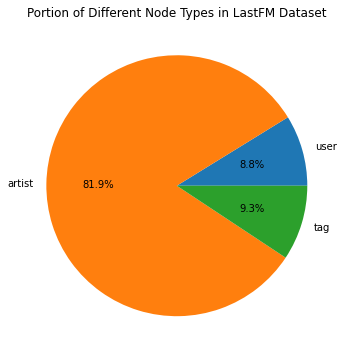

In [25]:
type_attribute_name = 'label'  # This is just an example; adjust it according to your graph's attribute names

# Extracting all node types based on the specified attribute
node_types = set(nx.get_node_attributes(nx_graph, type_attribute_name).values())

# Counting nodes for each type
node_type_counts = {node_type: 0 for node_type in node_types}
for _, node_data in nx_graph.nodes(data=True):
    node_type = node_data.get(type_attribute_name)
    if node_type in node_type_counts:
        node_type_counts[node_type] += 1

# Ensure that we remove any node type with a count of 0 (if any)
node_type_counts = {k: v for k, v in node_type_counts.items() if v > 0}

# Check to ensure we have valid data for plotting
if node_type_counts:
    # Plotting the pie chart
    plt.figure(figsize=(10, 6))
    plt.pie(node_type_counts.values(), labels=node_type_counts.keys(), autopct='%1.1f%%')
    plt.title('Portion of Different Node Types in LastFM Dataset')
    plt.show()
else:
    print("No node types with nodes found.")

### Popularity Analysis

In network analysis, such plots are often used to display the degree distribution of nodes in a graph. The X-axis represents the degree of nodes (often referred to as "popularity" in this context), and the Y-axis represents the number of nodes with that degree. When plotted on a log-log scale, many real-world networks exhibit a linear trend indicating a power-law distribution, which is characteristic of scale-free networks where a few nodes (hubs) have significantly higher degrees compared to the rest.

To recreate a plot like this, you'll want to:
- Calculate the degree of each node in the network.
- Count how many nodes have each degree.
- Plot the degree counts on a log-log scale.

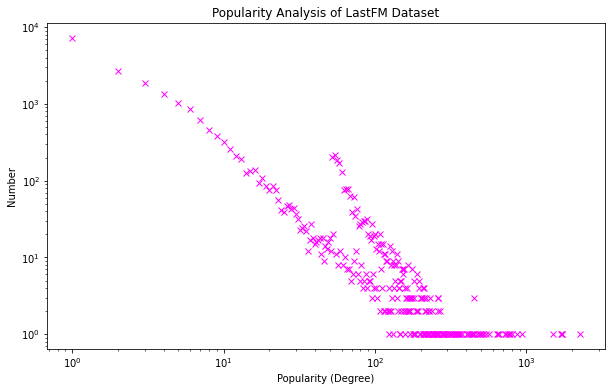

In [27]:
from collections import Counter

# Assuming your graph is stored in `nx_graph`

# Calculate the degrees of all nodes in the graph
degrees = [degree for node, degree in nx_graph.degree()]

# Count how many times each degree occurs in the network
degree_counts = Counter(degrees)

# Prepare the data for plotting
degrees, counts = zip(*degree_counts.items())

# Create a log-log plot of the degree distribution
plt.figure(figsize=(10, 6))
plt.loglog(degrees, counts, marker='x', linestyle='None', color='magenta')

# Adding titles and labels
plt.title("Popularity Analysis of LastFM Dataset")
plt.xlabel("Popularity (Degree)")
plt.ylabel("Number")

# Show the plot
plt.show()
